In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import Imreduction, gp2idomain, gp2cellids,cellidBD, get_heads, get_spdis, get_MNTbbox

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "workingDis"
model_name="dis_test"
exe_name="../../exe/mf6"
R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
Agly_path="../data/Fleuves/Agly_ludo.shp" # path to Agly
MNT_path= "../../../../../MNT_demo_5m.tif"

# get x0,y0,y1 and x1
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

In [3]:
#spatial parameters
Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = 150
nrow = 150
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -100
top = 10.
idomain = np.zeros((nrow*ncol))

In [21]:
R = gp.read_file(R_path) # import shapefile with geopandas
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=3)

In [5]:
#BC Agly
BC_Agly = gp.read_file(Agly_path)
#BC_Agly = BC_Agly.sort_values(by="ORDRE").set_index("ORDRE") # sort multilines by the ORDRE column, not necessary with the new file that I created

In [20]:
ix = GridIntersect(grid, method="structured") # structured doesn't work everytime... 
                                             # but it allows to keep the order of the cells !
lst_Agy = [];lst_Agy_long=[];o = 0

for i in range(BC_Agly.shape[0]):
    cellids = ix.intersect_linestring(BC_Agly.iloc[i].geometry).cellids
    long = ix.intersect_linestring(BC_Agly.iloc[i].geometry).lengths
    for irow,icol in cellids:
        
        cell_riv = (0,irow,icol)
        if (cell_riv not in lst_Agy):
            lst_Agy.append(cell_riv)
            lst_Agy_long.append(long[o])
            o = o + 1
            
# calculate the heads along the river
lst_Agy_long = np.array(lst_Agy_long) # make an array
H_us = 30 # head up stream
H_ds = 0 # head down stream
dh_dl = (H_ds-H_us)/lst_Agy_long.sum() #slope of the head along the river (linear interpolation)

H_riv = np.zeros(lst_Agy_long.shape[0], dtype=np.float) # initiate an array for the head in the river

for idx in range(lst_Agy_long.shape[0]): # loop for calculating the heads (can also be used for interpolate the botm of the river)
    if idx == 0:
        len_cum = 0.5 * lst_Agy_long[0]
    else:
        len_cum += 0.5 * (lst_Agy_long[idx-1]+lst_Agy_long[idx])
    H_riv[idx] = H_us + len_cum * dh_dl

In [19]:
## this block extracts coordinates of the points in the shapefile (Linestring already ordered) and extract cellids one by one of each segement
# IN THE RIGHT ORDER, also extract the length of each segment in each cells

ix = GridIntersect(grid)
coord_agly=[]
for x,y in zip(BC_Agly.geometry[0].xy[0],BC_Agly.geometry[0].xy[1]):
    coord_agly.append((x,y))

cellids_agy=[];verti=[];df_tot_ord = pd.DataFrame()

for i in range(len(coord_agly)):
    if i < len(coord_agly)-1:
        lsi = LineString([coord_agly[i],coord_agly[i+1]]) # create the linestring btw point i and i+1
        res = ix.intersect_linestring(lsi) # do the intersection
        cellids = res.cellids # extract cellids
        
        if len(cellids)>1: # if more than one cells is intersected --> we need to order them
            
            dirx = coord_agly[i+1][0]-coord_agly[i][0] # direction of the linestring
            diry = coord_agly[i+1][1]-coord_agly[i][1]
            
            for x,y in res.vertices: # extract the 1st vertice of the intersections in order to organize 
                verti.append(x)
            vertix = np.array(verti)[:,0]
            vertiy = np.array(verti)[:,1]
            df = pd.DataFrame({"cellids":cellids,"vertix":vertix,"vertiy":vertiy,"lengths":res.lengths}) # create a DF to order
            
            #organize given the direction
            if diry > 0 and dirx > 0:
                df.sort_values(by=["vertix","vertiy"],ascending=[True,True],inplace=True)
                
            if diry < 0 and dirx < 0:
                df.sort_values(by=["vertix","vertiy"],ascending=[False,False],inplace=True)
                
            if diry > 0 and dirx < 0:
                df.sort_values(by=["vertix","vertiy"],ascending=[True,False],inplace=True)    
            
            # append these data in a big DF
            df_tot_ord = df_tot_ord.append(df).drop(["vertix","vertiy"],axis=1)
            
            for irow,icol in df.cellids:
                cell_riv = (0,irow,icol)
                if (cell_riv not in cellids_agy):
                    cellids_agy.append(cell_riv)
                    idomain[irow*grid.ncol+icol] = 1
            verti=[];
            
            
        else : # if only one cell is intersected by the linestring
            df_tot_ord = df_tot_ord.append(pd.DataFrame({"cellids":cellids,"lengths":res.lengths}))
            for irow,icol in cellids:
                cell_riv = (0,irow,icol)
                if (cell_riv not in cellids_agy):
                    cellids_agy.append(cell_riv)
                    idomain[irow*grid.ncol+icol]=1
                    
lst_len_Agy = df_tot_ord.groupby(["cellids"],sort=False).sum()["lengths"].values

In [8]:
lst_Agy_long = np.array(lst_len_Agy) # make an array
H_us = 30 # head up stream
H_ds = 0 # head down stream
dh_dl = (H_ds-H_us)/lst_Agy_long.sum() #slope of the head along the river (linear interpolation)

H_riv = np.zeros(lst_Agy_long.shape[0], dtype=np.float) # initiate an array for the head in the river

for idx in range(lst_Agy_long.shape[0]): # loop for calculating the heads (can also be used for interpolate the botm of the river)
    if idx == 0:
        len_cum = 0.5 * lst_Agy_long[0]
    else:
        len_cum += 0.5 * (lst_Agy_long[idx-1]+lst_Agy_long[idx])
    H_riv[idx] = H_us + len_cum * dh_dl

In [9]:
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

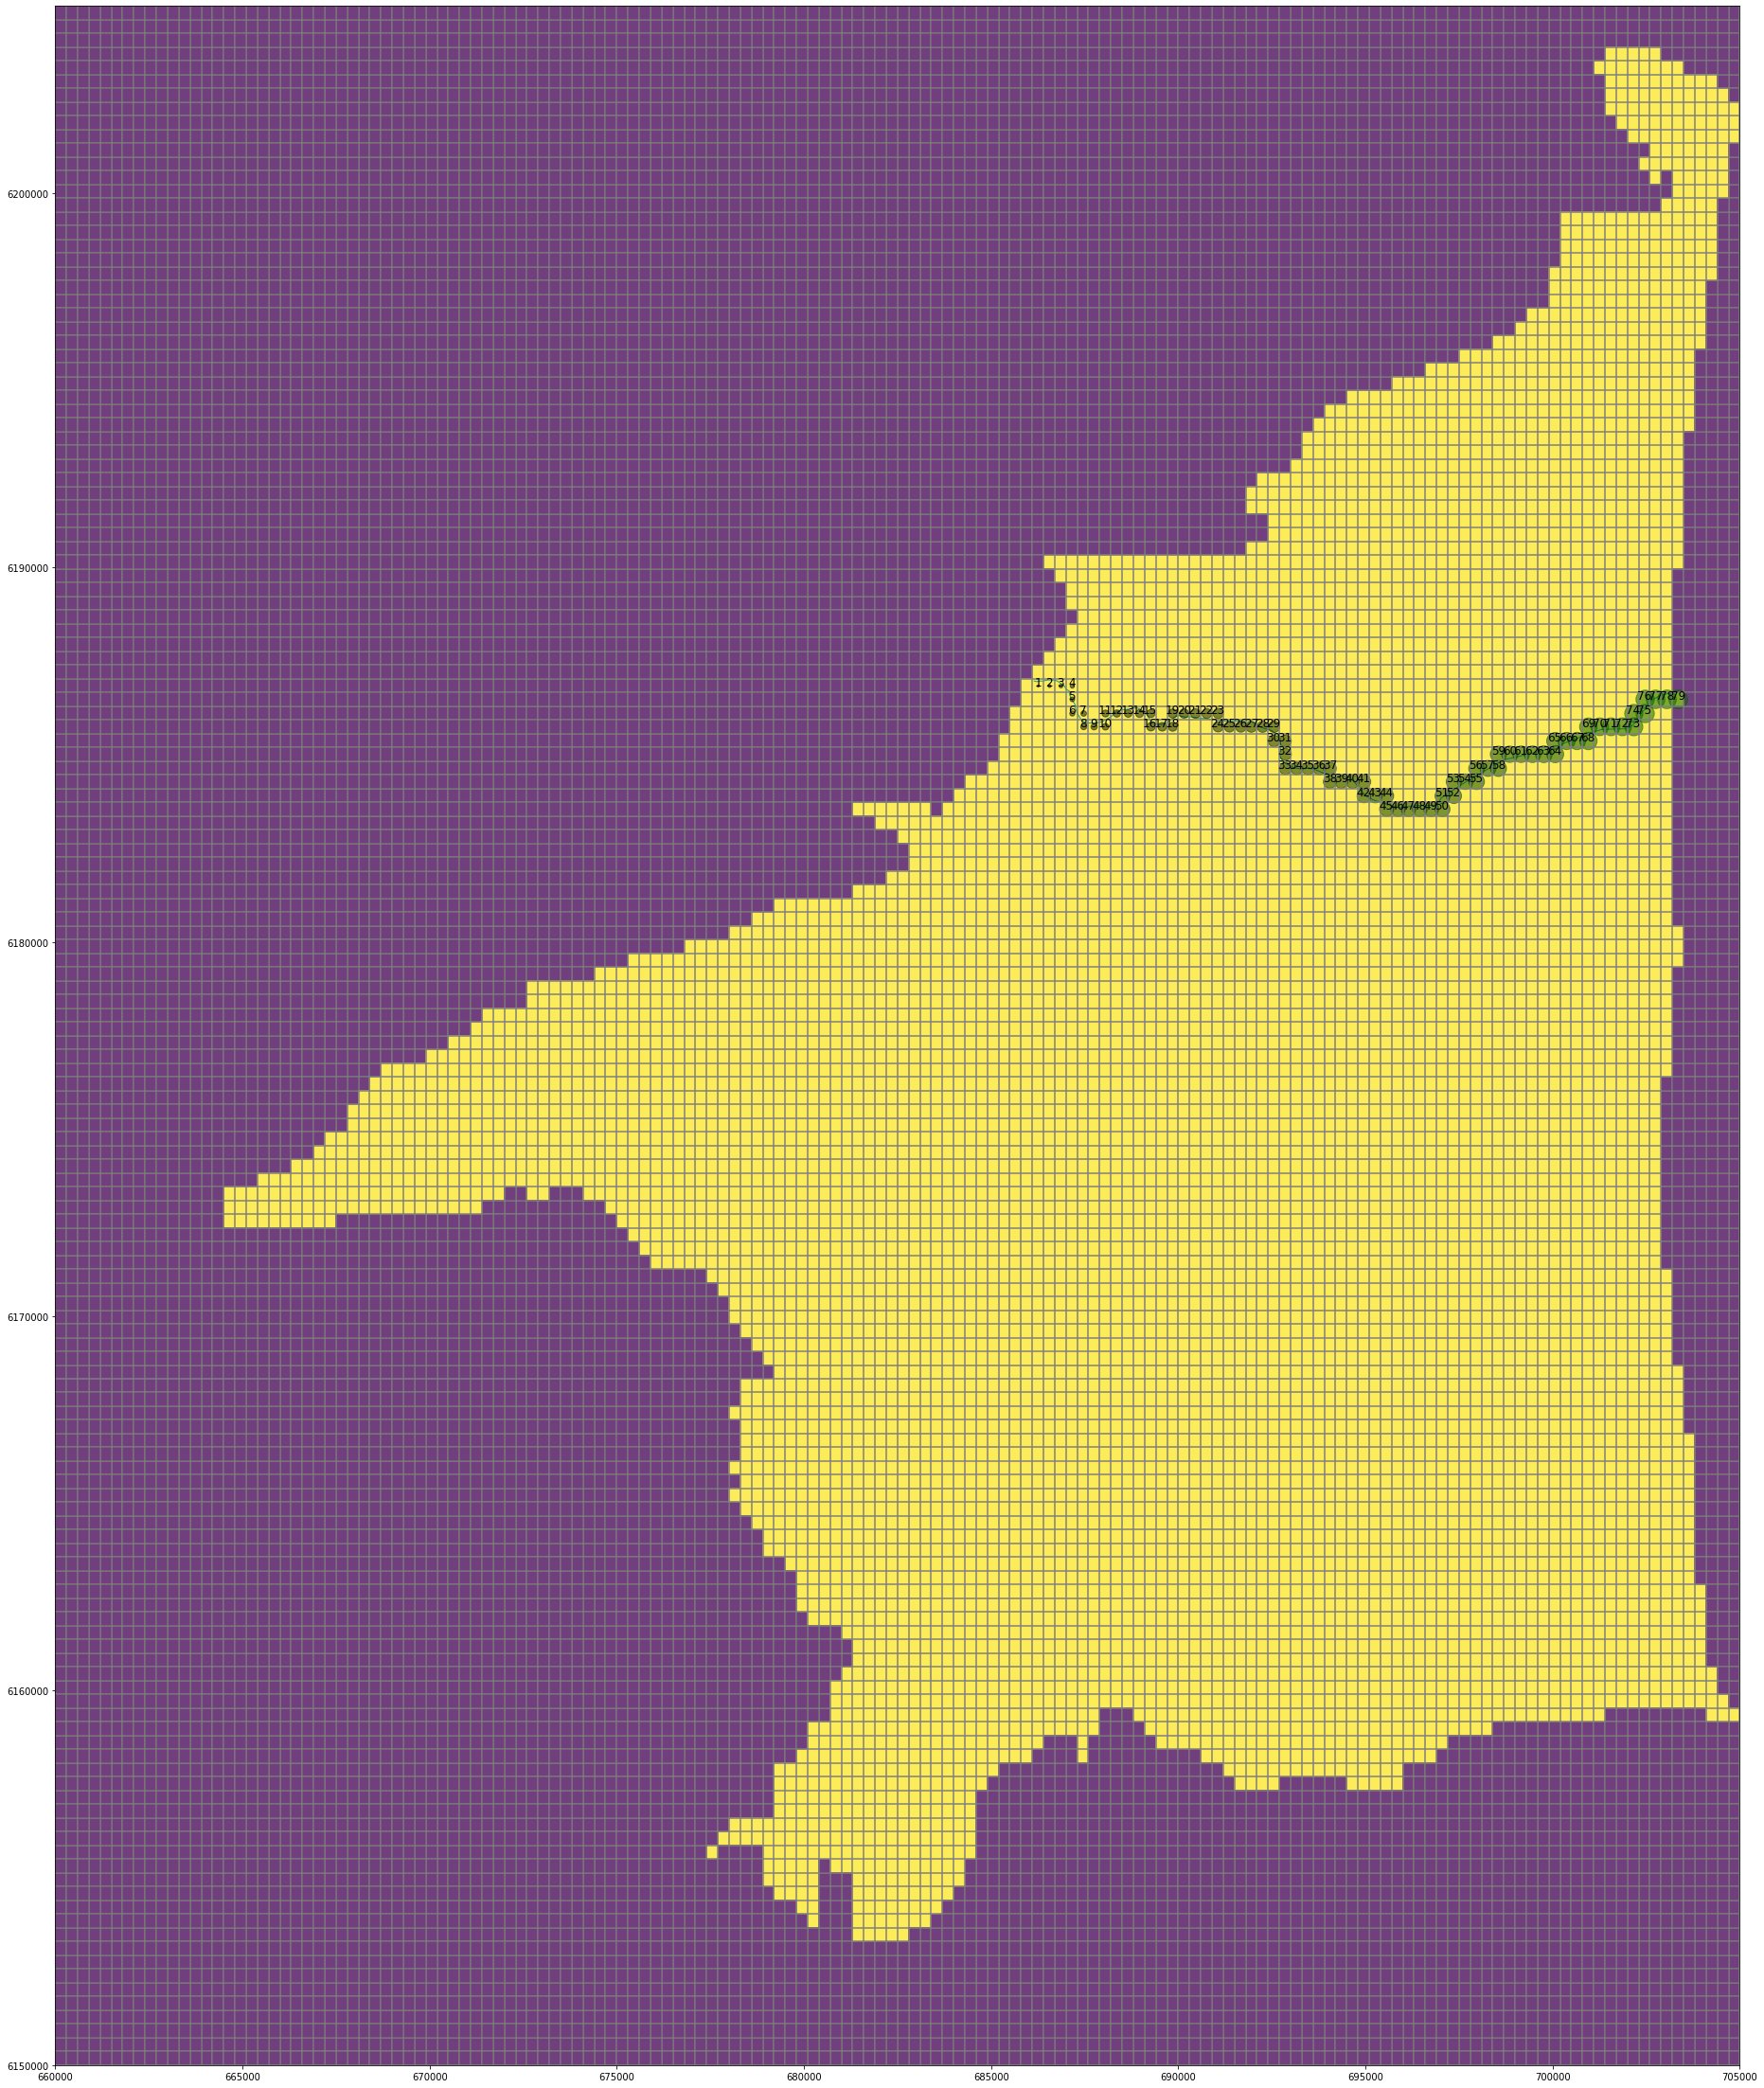

In [24]:
fig = plt.figure(figsize=(40,40))
ax = fig.add_subplot(aspect='equal')

mm = fp.plot.PlotMapView(model=gwf)
mm.plot_array(dis.idomain.array,alpha=0.5)
#fp.plot.plot_shapefile(R_path,ax=ax,facecolor = "brown",alpha=0.5)
fp.plot.plot_shapefile(Agly_path,ax=ax,facecolor="none",linewidth = 1)
mm.plot_grid()


o =0
for i,j,k in cellids_agy:
    o = o + 1
    plt.scatter(gwf.modelgrid.xcellcenters[j,k],gwf.modelgrid.ycellcenters[j,k],s=o*5,alpha=0.5,c=([0,0.005*o,0]))
    plt.text(gwf.modelgrid.xcellcenters[j,k],gwf.modelgrid.ycellcenters[j,k],"{}".format(o),size=12,ha="center")
    